# Multiomics Cancer Classification

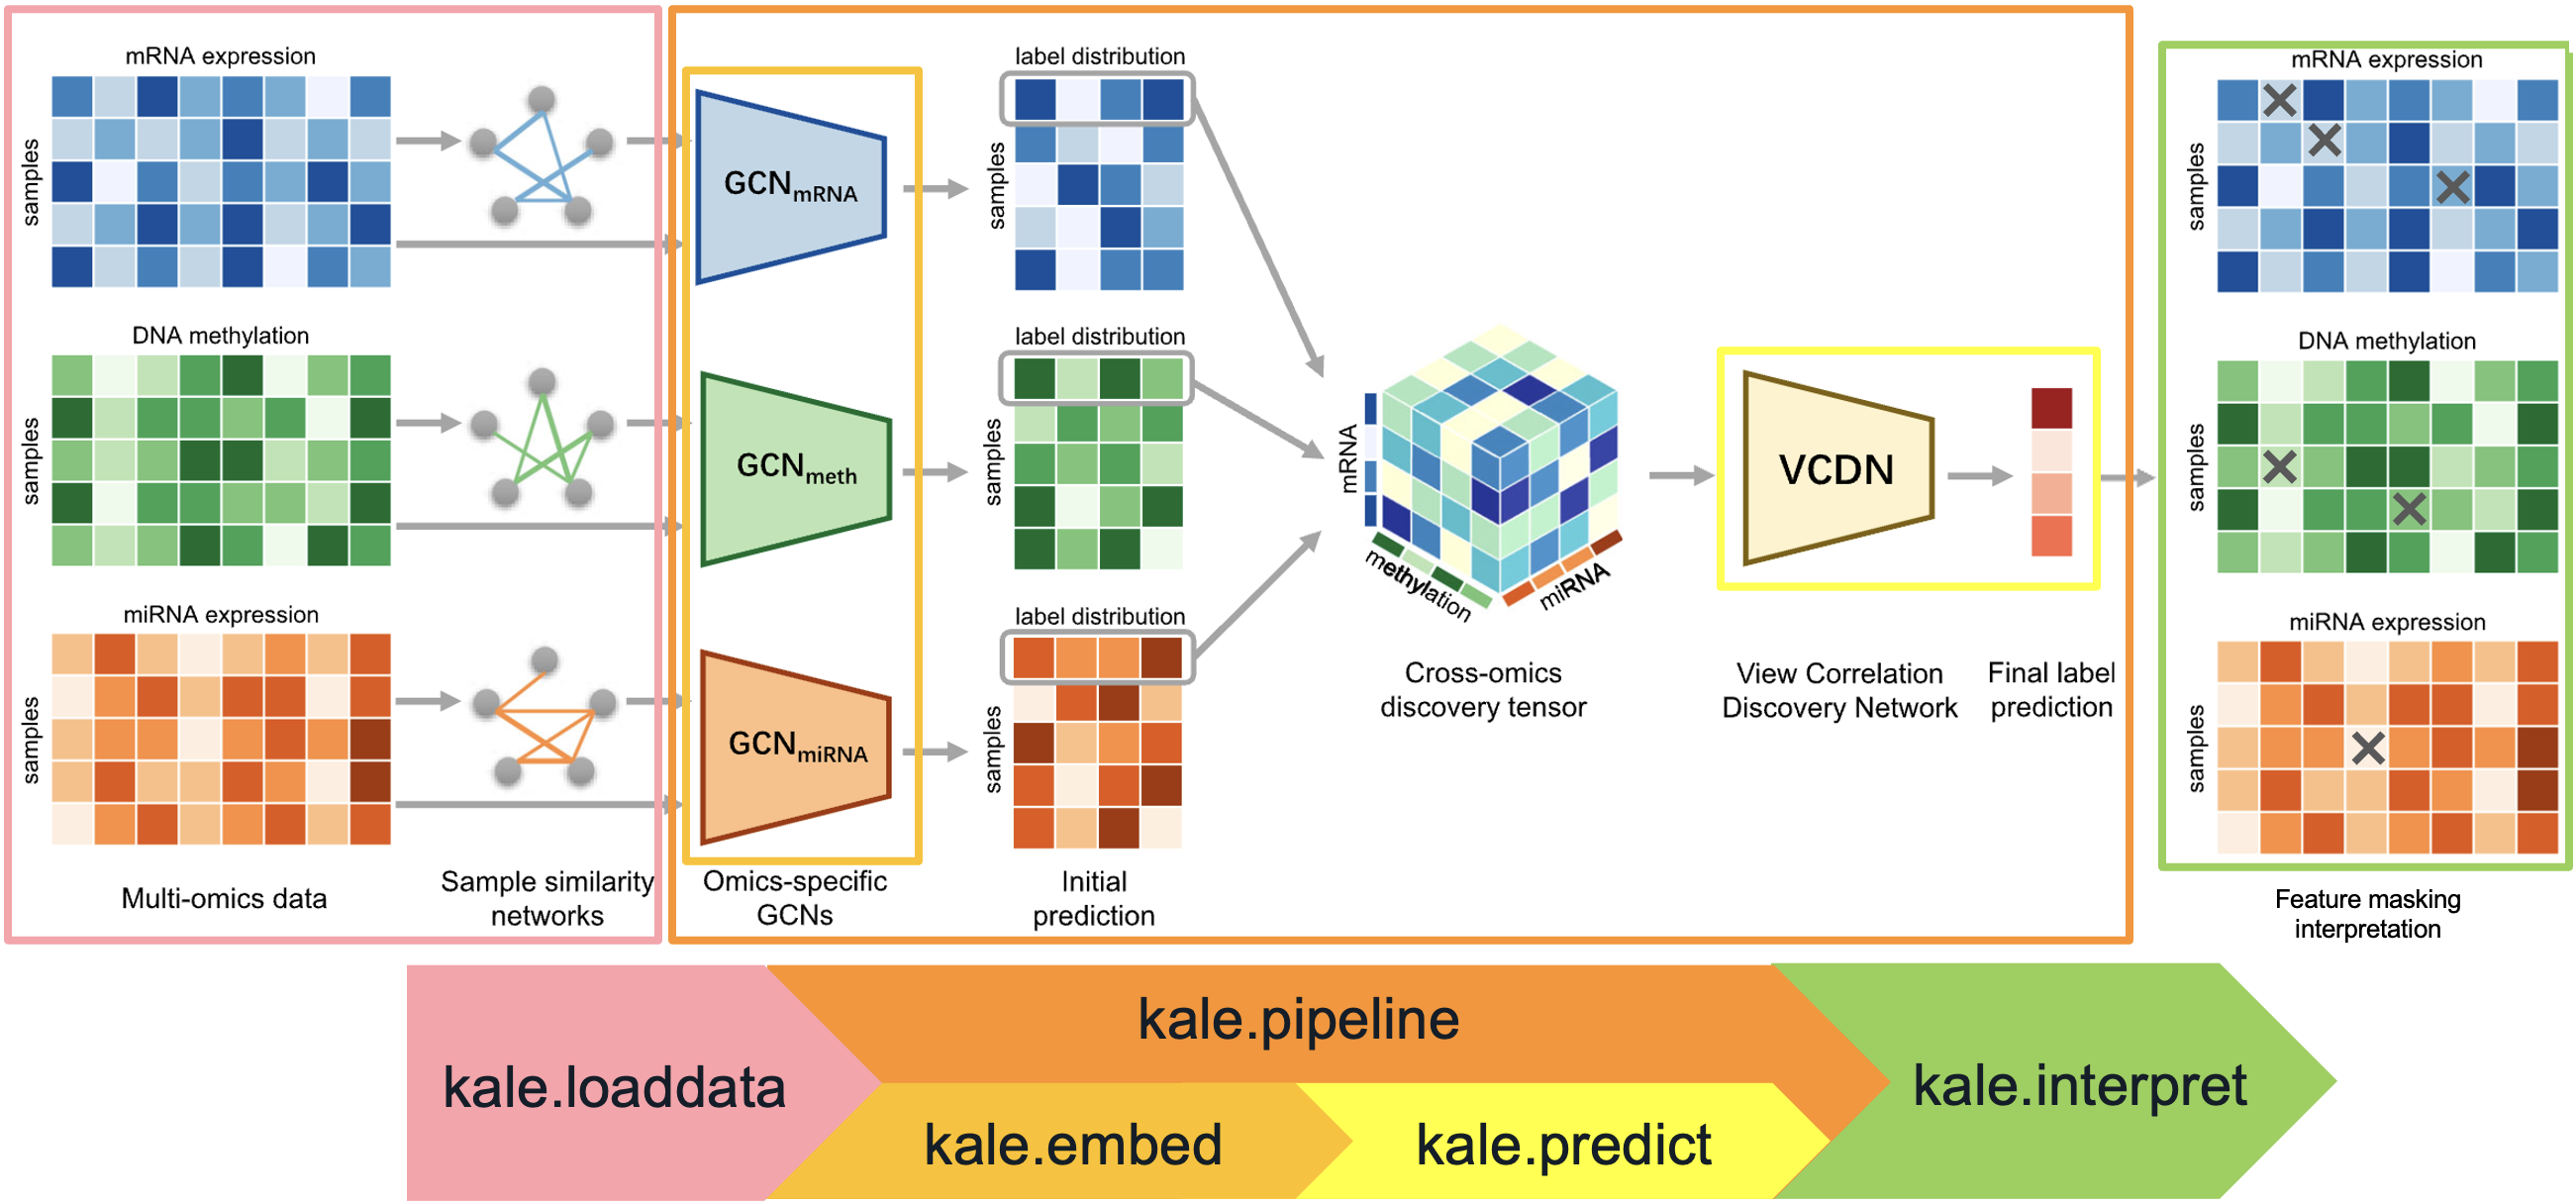

In this tutorial, we demonstrate how to use the standard pipeline in `PyKale` to integrate **patient multiomics data** in **cancer classification**.
We use **M**ulti-**O**mics **G**raph c**O**nvolutional **NET**works (MOGONET) by **Huang et al. (Nature Communication, 2021)** as an example.

This tutorial is about cancer subtypes classification problem, which is a multi-class classification problem. The input is the multiomics data from patient, including mRNA expression data, DNA methylation data, and miRNA expression data. The output will be the subtype of cancers. We have two datasets to work with, **BRCA** and **ROSMAP**. BRCA has five subtypes and ROSMAP has only two.

## Step 0: Environment Preparation

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook's current directory. Two additional helper scripts are:
- [`config.py`](https://github.com/pykale/mmai-tutorial/blob/main/tutorials/multiomics-cancer-classification/config.py): Defines the base configuration settings, which can be overridden using a custom `.yaml` file.
- [`model.py`](https://github.com/pykale/mmai-tutorial/blob/main/tutorials/multiomics-cancer-classification/model.py): Defines the network structure of MOGONET.

To prepare the helper functions and necessary materials, we download them from the GitHub repository.

In [ ]:
!rm -rf /content/mmai-tutorials
!git clone https://github.com/pykale/mmai-tutorials.git

### Package Installation

The main package required for this tutorial is `PyKale`.

`PyKale` is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

In [ ]:
!pip install --quiet git+https://github.com/pykale/pykale@main\
    && echo "PyKale installed successfully ✅" \
    || echo "Failed to install PyKale ❌"

Then, we install `PyG` (PyTorch Geometric) and related packages.

[**WARNING**] Please don't re-run this session after installation completed. Runing this installation multiple times will trigger issues related to `PyG`. If you want to re-run this installation, please click the `Runtime` on the top menu and choose `Disconnect and delete runtime` before installing.

In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"

Then, we install other required packages in [`mmai-tutorial/requirements.txt`](https://github.com/pykale/mmai-tutorial/blob/main/requirements.txt).

In [ ]:
%cd /content/mmai-tutorials/tutorials/multiomics-cancer-classification

!pip install --quiet -r /content/mmai-tutorials/requirements.txt \
    && echo "Required packages installed successfully ✅" \
    || echo "Failed to install required packages ❌"
!pip install yacs

[optional] For Colab users, please run the following block to reinstall `NumPy` to avoid bugs.

[**NOTE**] It is normal to have a crash message after running the following block. That is because we replace the version of `NumPy`. Please ignore it and continue running the blocks behind. **Please don't re-run the above blocks after the crashing message.**

In [ ]:
import os

!pip install --upgrade --force-reinstall numpy==2.0.0
os.kill(os.getpid(), 9)

We then hide the warnings messages to get a clear output.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

### Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a [`config.py`](https://github.com/pykale/mmai-tutorial/blob/main/tutorials/multiomics-cancer-classification/config.py) file that defines default parameters. These can be customized by supplying a `.yaml` configuration file, such as [`experiments/BRCA.yaml`](https://github.com/pykale/mmai-tutorial/blob/main/tutorials/multiomics-cancer-classification/experiments/BRCA.yaml) as an example.

First, we load the configuration from [`experiments/BRCA.yaml`](https://github.com/pykale/mmai-tutorial/blob/main/tutorials/multiomics-cancer-classification/experiments/BRCA.yaml).

In [ ]:
%cd /content/mmai-tutorials/tutorials/multiomics-cancer-classification

from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("experiments/BRCA.yaml")

Besides, we also provide a configuration file for another dataset **ROSMAP**, named [`experiments/ROSMAP.yaml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/multiomics-cancer-classification/experiments/ROSMAP.yaml). Users can try with this dataset later.

In this tutorial, we list the hyperparameters we would like users to play with outside the `.yaml` file:
- `cfg.SOLVER.MAX_EPOCHS_PRETRAIN`: Number of epochs in pre-training stage.
- `cfg.SOLVER.MAX_EPOCHS`: Number of epochs in training stage.
- `cfg.DATASET.NUM_MODALITIES`: Number of modalities in the pipeline.
  - `1`: mRNA expression.
  - `2`: mRNA expression + DNA methylation.
  - `3`: mRNA expression + DNA methylation + miRNA expression.

[**NOTE**] Because this tutorial aims to demonmstrate `PyKale` pipeline, we only set `cfg.SOLVER.MAX_EPOCHS_PRETRAIN=100` and `cfg.SOLVER.MAX_EPOCHS=500` to reduce the training time.
If users are interested, please increase them to get more accurate predictions.

In [ ]:
cfg.SOLVER.MAX_EPOCHS_PRETRAIN = 100
cfg.SOLVER.MAX_EPOCHS = 500
cfg.DATASET.NUM_MODALITIES = 3

Print hyperparameters:

In [ ]:
print(cfg)

## Step 1: Data Loading and Preparation

We use two multiomics benchmarks in this tutorial, BRCA and ROSMAP, which have been provided by the authors of MOGONET paper in [their repository](https://github.com/txWang/MOGONET).
A brief description of BRCA and ROSMAP dataset is shown in the following
table.

**Table 1**: Characteristics of the preprocessed BRCA multiomics dataset.

|      Omics       | #Training samples | #Test samples | #Features |
|:----------------:|:-----------------:|:-------------:|:---------:|
| mRNA expression  |        612        |      263      |   1000    |
| DNA methylation  |        612        |      263      |   1000    |
| miRNA expression |        612        |      263      |    503    |

**Table 2**: Characteristics of the preprocessed ROSMAP multiomics dataset.

|      Omics       | #Training samples | #Test samples | #Features  |
|:----------------:|:-----------------:|:-------------:|:----------:|
| mRNA expression  |        245        |      106      |    200     |
| DNA methylation  |        245        |      106      |    200     |
| miRNA expression |        245        |      106      |    200     |

The data downloading function has been integrated in `kale.loaddata.multiomics_datasets.SparseMultiomicsDataset`, which also included loading data from the raw `.csv` files and pre-processing data to the graphs we needed.

This function transforms tabular multiomics data into graph datasets by treating each patient sample as a node and using molecular measurements as node features. For each modality, it reads feature matrices and labels from `.csv` files, splits them into training and test sets.

Then, it samples similaity networks from the graphs as shown in the top figure. It computes sample similarities to define edges between nodes. These similarities are used to construct sparse adjacency matrices, where only the most relevant connections are retained.

Next, each graph is represented with node features, edge connections, and labels, encapsulating both feature and relational structure for downstream graph-based learning.



Delete the potential existing data and download new version:

In [ ]:
!rm -rf dataset/

To load data, we first define a list the names of data files:

In [ ]:
file_names = []
for modality in range(1, cfg.DATASET.NUM_MODALITIES + 1):
    file_names.append(f"{modality}_tr.csv")
    file_names.append(f"{modality}_lbl_tr.csv")
    file_names.append(f"{modality}_te.csv")
    file_names.append(f"{modality}_lbl_te.csv")
    file_names.append(f"{modality}_feat_name.csv")

Then, we download, load, and pre-process the data by `PyKale`.

In [ ]:
import torch
from kale.loaddata.multiomics_datasets import SparseMultiomicsDataset
from kale.prepdata.tabular_transform import ToOneHotEncoding, ToTensor

multiomics_data = SparseMultiomicsDataset(
    root=cfg.DATASET.ROOT,
    raw_file_names=file_names,
    num_modalities=cfg.DATASET.NUM_MODALITIES,
    num_classes=cfg.DATASET.NUM_CLASSES,
    edge_per_node=cfg.MODEL.EDGE_PER_NODE,
    url=cfg.DATASET.URL,
    random_split=cfg.DATASET.RANDOM_SPLIT,
    equal_weight=cfg.MODEL.EQUAL_WEIGHT,
    pre_transform=ToTensor(dtype=torch.float),
    target_pre_transform=ToOneHotEncoding(dtype=torch.float),
)

Inspect the dataset:

In [ ]:
print(multiomics_data)

## Step 2: Model Definition

`PyKale` applies `kale.embed` and `kale.predict` to define `MogonetModel` class in [`model.py`](https://github.com/pykale/mmai-tutorials/blob/main/tutorials/multiomics-cancer-classification/model.py), which wraps all the necessary components of the MOGONET pipeline based on the configuration.

This wrapper takes care of:
- Building GCN encoders for each omics modality.
- Creating linear classifiers for modality-specific outputs.
- Optionally initializing a VCDN decoder for multimodal fusion.

MOGONET consists of two major sections: modality-specific encoders to encode graph data into latent space, and View Correlation Discovery Network (VCDN) for multimodal feature fusion, as shown in the top figure.
The modalitity-specific encoders is called from `kale.embed` and VCDN along with the prediction head is integrated in `kale.predict`.

### Embedding Extraction

`PyKale` support graph convolutional neural networks (GCNs) in `kale.embed`, which is used as the modality-specific encoders for MOGONET.
GCNs are neural networks designed for graph data, which generalize convolution operations to graph-structured data by aggregating feature information from neighboring nodes.
Through GCN encoders in `PyKale`, we can encode the raw data to graph embeddings.

### Prediction of Cancer Subtypes

`PyKale` support prediction layers that output the final prediction of cancer subtypes according to the input embeddings.
In `kale.predict`, the VCDN of MOGONET fuses modality-specific predictions for final classification and captures correlations between different modalities at the decision level.
Besides, `PyKale` also call the linear classifier layer from `kale.predict.decode.LinearClassifier` to implement MOGONET.

### Descriptions of Other APIs in [`model.py`](https://github.com/pykale/mmai-tutorials/blob/main/tutorials/multiomics-cancer-classification/model.py)

[`model.py`](https://github.com/pykale/mmai-tutorials/blob/main/tutorials/multiomics-cancer-classification/model.py) also calls `kale.pipeline.multiomics_trainer`, which provides `MultiomicsTrainer`, the training and evaluation engine that orchestrates how unimodal encoders and the multimodal VCDN fusion layer work together. It supports pretraining and full training regimes.

To initialize the model, we firstly call `MogonetModel` from [`model.py`](https://github.com/pykale/mmai-tutorials/blob/main/tutorials/multiomics-cancer-classification/model.py).

In [ ]:
from model import MogonetModel

mogonet_model = MogonetModel(cfg, dataset=multiomics_data)

Visualize the model architecture:

In [ ]:
print(mogonet_model)

## Step 3: Model Training

### Pretrain Unimodal Encoders

Before training the multiomics model, we first pretrain encoders for each modality independently. This step helps each GCN encoder learn a good representation of its respective modality before integration.

We can define the trainer of pretraining stage by:

In [ ]:
import pytorch_lightning as pl

network = mogonet_model.get_model(pretrain=True)
trainer_pretrain = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS_PRETRAIN,
    default_root_dir=cfg.OUTPUT.OUT_DIR,
    accelerator="auto",
    devices="auto",
    enable_model_summary=False,
)

#### What Happens in Pretraining?
During this phase:

- Encoders for each modality are trained separately using its own GCN and classifier.

- No information is shared across modalities yet.

- This step ensures omics-specific features are well-learned before fusion.

Once pretrained, the model is ready for multimodal fusion training using the VCDN decoder.

We pretrain the model by:

In [ ]:
trainer_pretrain.fit(network)

### Train the Multimodal Model
After pretraining the unimodal pathways, we now train the full MOGONET model by enabling the VCDN. In this stage, all modality-specific encoders and VCDN are trained.

We define the trainer of multimodal training by:

In [ ]:
network = mogonet_model.get_model(pretrain=False)
trainer = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS,
    default_root_dir=cfg.OUTPUT.OUT_DIR,
    accelerator="auto",
    devices="auto",
    enable_model_summary=False,
    log_every_n_steps=1,
)

#### What Happens Here?
- The pretrained unimodal encoders are reused as feature extractors.

- The VCDN decoder is trained to integrate outputs across all modalities.

- This setup allows joint learning from all omics data types for improved cancer classification performance.

We start the multimodal training by:

In [ ]:
trainer.fit(network)

## Step 4: Evaluation
Once training is complete, we evaluate the model on the test set using `trainer.test()`.

### What is included in this step?
- Load the best model checkpoint.
- Run the model on the test split from the dataset.
- Return classification metrics such as accuracy, F1 score, etc.

In [ ]:
trainer.test(network)

## Step 5: Interpretation

To better understand which features among multiomics data are the key biomarkers in cancer subtype classification and how decisions were made by the model, we perform an interpretation study to identify important biomarkers.
We identify the most influential features (biomarkers) using **feature-masking-based importance analysis**.

We use `kale.interpret` to perform interpretation, where a function that systematically masks input features and observes the effect on performance—highlighting which features are most important for classification is provided.

### How Feature Importance Is Computed?
The `select_top_features_by_masking` function in `PyKale` implements a feature ablation approach to estimate feature importance for multi-omics data.

For each feature in each modality:

- Temporarily mask (zero out) the feature.

- Evaluate the model on the test set.

- Measure the performance drop (e.g., in F1 score). The larger the drop, the more important the feature is.

- Importance is calculated as $Importance_j=(FullMetric-MaskedMetric_j)\times d$,
where $j$ is the feature index and $d$ is the number of features in the modality (to scale the effect)
For demonstration, we use **F1 score** as the metric to calculate feature importance.

Because the interpretation study needs us to mask one feature and observe the performance drop, we firstly define the trainer for the interpretation experiments.

[**NOTE**] To reduce the running time in the tutorial, we set `cfg.SOLVER.MAX_EPOCHS` to 1. Therefore, the final results may be different from what they should be. Users can try to increase `cfg.SOLVER.MAX_EPOCHS` later.

In [ ]:
from kale.interpret.model_weights import select_top_features_by_masking
import pytorch_lightning as pl

trainer_biomarker = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=False,
)

Then, we start the experiment.

To supress the verbose messages in the following experiments:

In [ ]:
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

Run the interpretation experiments:

[**WARNING**] Because the following block will train the model for 2,503 times for BRCA dataset, the following block may take about 6 minutes.

In [ ]:
f1_key = "F1" if multiomics_data.num_classes == 2 else "F1 macro"
df_featimp_top = select_top_features_by_masking(
    trainer=trainer_biomarker,
    model=network,
    dataset=multiomics_data,
    metric=f1_key,
    num_top_feats=30,
    verbose=False,
)

Print the most important features:

In [ ]:
print("{:>4}\t{:<20}\t{:>5}\t{}".format("Rank", "Feature name", "Omics", "Importance"))
for rank, row in enumerate(df_featimp_top.itertuples(index=False), 1):
    print(f"{rank:>4}\t{row.feat_name:<20}\t{row.omics:>5}\t{row.imp:.4f}")

### Full results of interpretation study

We attach the full results of most important features reported in the original paper for reference:

**Table 3**: Important features in BRCA dataset.

|      Omics       | Importance features |
|:----------------:|:---------------------------------------------:|
| mRNA expression  |       SOX11, AMY1A, SLC6A15, FABP7, SLC6A14, SLC6A2, FGFBP1, DSG1, UGT8, ANKRD45, PI3, SERPINB5, COL11A2, ARHGEF4, SOX10    |
| DNA methylation  |       GPR37L1, MIR563, OR1J4, ATP10B, KRTAP3-3, FLJ41941, TMEM207, CDH26, MT1DP    |
| miRNA expression |       hsa-mir-205, hsa-mir-187, hsa-mir-452, hsa-mir-20b, hsa-mir-224, hsa-mir-204    |

**Table 4**: Important features in ROSMAP dataset.

|      Omics       | Importance features |
|:----------------:|:---------------------------------------------:|
| mRNA expression  |       NPNT, CDK18, KIF5A, SPACA6, TCEA3, SYTL1, ARRDC2, APLN    |
| DNA methylation  |       TMC4, AGA, HYAL2, CCL3, TTC15    |
| miRNA expression |       hsa-miR-423-3p, hsa-miR-33a, hsa-miR-640, hsa-miR-362-3p, hsa-miR-491-5p, hsa-miR-206, hsa-miR-548b-3p, hsa-miR-127-3p, hsa-miR-106a_hsa-miR-17, hsa-miR-424, hsa-miR-577, hsa-miR-873, hsa-miR-651, hsa-miR-199b-5p, hsa-miR-192, hsa-miR-199a-5p, hsv1-miR-H1    |

## Extension Tasks
### Task 1 - Unimodal v.s. Multimodal
Users can try to set the `cfg.DATASET.NUM_MODALITIES=1` to try only using single mRNA experission for prediction and compare its results with the ones using all three modalities.

### Task 2 - Try another dataset
To try ROSMAP dataset, replace `"experiments/BRCA.yaml"` with `"experiments/ROSMAP.yaml"` in the following line under Configuration section and run the pipeline again.
```python
cfg.merge_from_file("experiments/BRCA.yaml")
```